In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers, utils, initializers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import linkpred
from linkpred.evaluation import Pair
import seaborn as sns

In [4]:
import sklearn.metrics as metrics

In [5]:
from gensim.models import Word2Vec

In [6]:
with open('universe_1057.pickle', 'rb') as f:
    universe_1057 = pickle.load(f)

In [7]:
with open('universe_597.pickle', 'rb') as f:
    universe_597 = pickle.load(f)

In [8]:
len(universe_597)

177310

In [9]:
embedding_pickle_597 = pd.read_pickle('embedding_pickle_597.csv')

In [10]:
edges_597 = pd.read_pickle('edges_original_597.csv')

In [11]:
embedding_pickle_1057 = pd.read_pickle('embedding_pickle_1057.csv')

In [12]:
edges_1057 = pd.read_pickle('edges_original_1057.csv')

In [13]:
H_597 = nx.read_graphml("H_597.graphml")

In [14]:
all_unconnected_pairs_597 = []

In [15]:
def check_isequal(x, a, b):
    if x[0] == a:
        if x[1] == b:
            return True
    if x[1] == a:
        if x[0] == b:
            return True
    return False

In [16]:
for ui in universe_597:
    is_not = False
    for i,j in edges_597.values:
        if check_isequal(ui, i, j):
            is_not = True
            break
    if not is_not:
        all_unconnected_pairs_597.append((ui[0], ui[1]))

In [17]:
len(all_unconnected_pairs_597)

159299

In [18]:
word2vec_597 = Word2Vec.load("word2vec_597.model")

Collegamenti inesistenti => target negativo

In [19]:
node_1_unlinked = [word2vec_597.wv[i[0]] for i in all_unconnected_pairs_597]
node_2_unlinked = [word2vec_597.wv[i[1]] for i in all_unconnected_pairs_597]

data_597 = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data_597['link'] = 0

In [20]:
data_597

,node_1,node_2,link
0,"[-0.011774609, 0.0046127765, -0.00472879, 0.00...","[0.002430141, 0.005948343, -0.0064370288, -0.0...",0
1,"[0.0059981416, 0.0073024086, 0.004203002, -0.0...","[0.0036992745, 0.0004444936, -0.008025685, 0.0...",0
2,"[0.009794094, 0.0039510047, 0.0069019194, 0.00...","[-0.0034460786, -0.004708949, 0.0045025223, -0...",0
3,"[-0.004782298, 0.0074075586, -0.009036621, -0....","[-0.0034505723, 0.009572382, -0.0048857573, 0....",0
4,"[0.002739371, -0.0048046284, 0.00023794279, 0....","[-0.008666487, -0.003407089, -0.007918215, -0....",0
...,...,...,...
159294,"[0.00699057, 0.0040628863, -0.0029240248, -0.0...","[-0.011997137, 0.014423813, 0.007390902, 0.002...",0
159295,"[-0.00059777295, 0.0035773763, -0.005621225, 0...","[0.008405226, -0.0013860974, 0.0076969857, 0.0...",0
159296,"[0.007691934, -0.0004352603, -0.003290561, 0.0...","[0.00667359, -0.0026248435, -0.004343857, 0.00...",0
159297,"[-0.004913537, 0.0014920309, -0.0062141786, -0...","[0.0064745815, 0.004576001, 0.0070170783, -0.0...",0


In [21]:
def omissibile_links(G, df_edges):
    initial_node_count = len(G.nodes)

    fb_df_temp = df_edges.copy()

    # empty list to store removable links
    omissible_links_index = []

    for i in tqdm(df_edges.index.values):

      # remove a node pair and build a new graph
      G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "first", "second", create_using=nx.Graph())

      # check there is no spliting of graph and number of nodes is same
      if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)
    return omissible_links_index

In [22]:
omissible_links_597 =  omissibile_links(H_597, edges_597)

100%|████████████████████████████████████████████████████████████████████████████| 18011/18011 [06:53<00:00, 43.51it/s]


In [28]:
len(edges_597)

18011

In [26]:
len(omissible_links_597)

17416

In [30]:
len(universe_597)

177310

In [23]:
# create dataframe of removable edges
fb_df_ghost_597 = embedding_pickle_597.loc[omissible_links_597]

fb_df_ghost_597 = fb_df_ghost_597.rename(columns={"first": "node_1", "second": "node_2"})
# add the target variable 'link'
fb_df_ghost_597['link'] = 1

data_597 = data_597.append(fb_df_ghost_597[['node_1', 'node_2', 'link']], ignore_index=True)

In [24]:
data_597['link'].value_counts()

0    159299
1     17416
Name: link, dtype: int64

In [25]:
data_597.to_pickle("data_597.csv")

----------------- Lettura dati -------------------

In [8]:
data_597 = pd.read_pickle('data_597.csv')

# 2 - Classificatori

In [6]:
X_597 = []
for i in range(data_597.shape[0]):
    first = data_597.iloc[i][0]
    second = data_597.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_597.append(mixed)

In [7]:
xtrain_597, xtest_597, ytrain_597, ytest_597 = train_test_split(np.asarray(X_597), data_597['link'], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=data_597['link'])

### 1 - DecisionTree

In [6]:
from sklearn import tree
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [59]:
# Set the parameters by cross-validation
tuned_parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
}
scores = ['roc_auc']

In [57]:
def builtGridSearch( X_train, X_test, y_train, y_test, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("------- Score = " + str(score) + " ------- \n")
        model = tree.DecisionTreeClassifier()
        k_fold = StratifiedKFold(n_splits=5, random_state=42)
        
        print("> Fold = " + str(k_fold) + "\n")
        clf = GridSearchCV(model, tuned_parameters, error_score='raise', cv=5, scoring = score, return_train_score=True)

        clf.fit(X_train, y_train)

        print("> Best Parameter set: \n")
        best = clf.best_params_
        print(best)
        
        print("\n> Grid scores:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
        parameters = {"criterion": [], "max_depth": [], "min_samples_leaf": [], "min_samples_split": []}
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
            parameters["criterion"].append(params["criterion"])

            if(params["max_depth"] == None):
                parameters["max_depth"].append(0)
            else:
                parameters["max_depth"].append(params["max_depth"])

            #parameters["max_depth"].append(params["max_depth"])
            parameters["min_samples_leaf"].append(params["min_samples_leaf"])
            parameters["min_samples_split"].append(params["min_samples_split"])
        
        print("-> Report\n") 
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print("\n")
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))

        
        # Creazione del csv
        d = {score: means, 'std_dev': stds*2, 'criterion': parameters["criterion"], "max_depth": parameters["max_depth"], "min_samples_leaf": parameters["min_samples_leaf"], "min_samples_split": parameters["min_samples_split"]}
        
        dataF = pd.DataFrame(data=d)
        
        dataF.to_csv("result_DT_gridsearch.csv",index=False, header=True)
        

        print("...........RESULTS FOR TRAINING.........")
        print("........................................")
        means = clf.cv_results_['mean_train_score']
        stds = clf.cv_results_['std_train_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))        
        
        print("____________________________________________")
        
        optimals[score] = best
    return optimals

In [42]:
optimals_597 = builtGridSearch(xtrain_597, xtest_597, ytrain_597, ytest_597, tuned_parameters, scores)

------- Score = roc_auc ------- 

> Fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


> Best Parameter set: 

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 10}

> Grid scores:

0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 20}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.533 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 20}
0.533 (+/-0.01

In [43]:
optimals_597

{'roc_auc': {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 20,
  'min_samples_split': 10}}

In [18]:
model_597 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
model_597.fit(xtrain_597, ytrain_597)
y_pred_597 = model_597.predict(xtest_597)

In [19]:
y_score_597 = model_597.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score_597[:, 1])
roc_auc0_597 = auc(fpr0, tpr0)

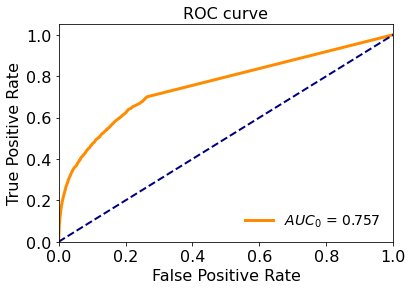

In [20]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0_597))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 1 - DecisionTree_Bilanciato

In [9]:
remove_n = data_597['link'].value_counts()[0] - data_597['link'].value_counts()[1]
remove_n

141883

In [11]:
df = data_597.copy()
drop_indices = np.random.choice(df[df["link"]==0].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
print(df_subset['link'].value_counts())

X_sbset_597 = []
for i in range(df_subset.shape[0]):
    first = df_subset.iloc[i][0]
    second = df_subset.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_sbset_597.append(mixed)
    
    
xtrain_sb_597, xtest_sb_597, ytrain_sb_597, ytest_sb_597 = train_test_split(np.asarray(X_sbset_597), df_subset["link"], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=df_subset["link"])

1    17416
0    17416
Name: link, dtype: int64


In [ ]:
optimals_sb_597 = builtGridSearch(xtrain_sb_597, xtest_sb_597, ytrain_sb_597, ytest_sb_597, tuned_parameters, scores)

In [21]:
model_sb_597 = tree.DecisionTreeClassifier(criterion = "gini", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
model_sb_597.fit(xtrain_sb_597, ytrain_sb_597)

DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=10)

In [22]:
y_score_sb_597 = model_sb_597.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score_sb_597[:, 1])
roc_auc0_dt_597_sb = auc(fpr0, tpr0)

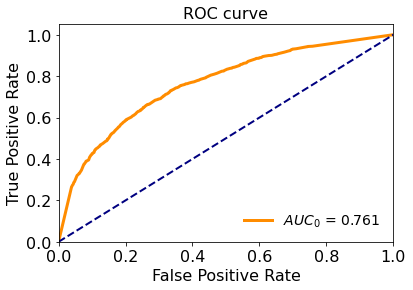

In [23]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0_dt_597_sb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 2 - Regressione logistica

In [61]:
lr = LogisticRegression()
lr.fit(xtrain_597, ytrain_597)
predictions = lr.predict_proba(xtest_597)

In [62]:
y_score = lr.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

0.6910504349671759


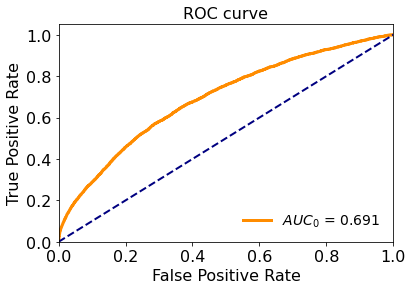

In [63]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 2 - Regressione Logistica_Bilanciata

In [64]:
lr = LogisticRegression()
lr.fit(xtrain_sb_597, ytrain_sb_597)

LogisticRegression()

In [65]:
y_score = lr.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

0.677879718870905


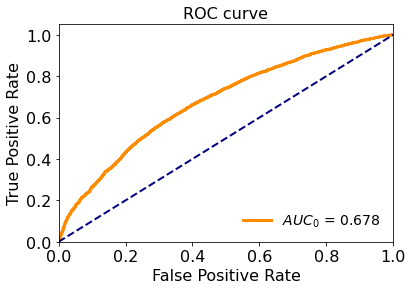

In [66]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 3 - LGBM

In [33]:
new_xtrain_597, xval_597, new_ytrain_597, yval_597 = train_test_split(xtrain_597, ytrain_597, 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=ytrain_597)

In [34]:
import lightgbm as lgbm

In [35]:
train_data = lgbm.Dataset(new_xtrain_597, new_ytrain_597)
test_data = lgbm.Dataset(xval_597, yval_597)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

y_pred = model.predict(xtest_597)

[LightGBM] [Info] Number of positive: 8534, number of negative: 78056
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49997
[LightGBM] [Info] Number of data points in the train set: 86590, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098556 -> initscore=-2.213368
[LightGBM] [Info] Start training from score -2.213368
[1]	valid_0's auc: 0.757326
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.791043
[3]	valid_0's auc: 0.810491
[4]	valid_0's auc: 0.823219
[5]	valid_0's auc: 0.831246
[6]	valid_0's auc: 0.837601
[7]	valid_0's auc: 0.842885
[8]	valid_0's auc: 0.845428
[9]	valid_0's auc: 0.84921
[10]	valid_0's auc: 0.851657
[11]	valid_0's auc: 0.855087
[12]	valid_0's auc: 0.857813
[13]	valid_0's auc: 0.859107
[14]	valid_0's auc: 0.860044
[15]	valid_0's auc: 0.861246
[16]	valid_0's a

In [36]:
y_pred

array([0.07833624, 0.03502418, 0.12256976, ..., 0.26043244, 0.123401  ,
       0.48227945])

In [37]:
fpr0, tpr0, _ = roc_curve(ytest_597, y_pred)
roc_auc_lgbm = auc(fpr0, tpr0)
print(roc_auc_lgbm)

0.8955829641443676


### 3 - LGBM_Bilanciato

In [39]:
new_xtrain_sb_597, xval_sb_597, new_ytrain_sb_597, yval_sb_597 = train_test_split(xtrain_sb_597, ytrain_sb_597, 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=ytrain_sb_597)

In [40]:
train_data = lgbm.Dataset(new_xtrain_sb_597, new_ytrain_sb_597)
test_data = lgbm.Dataset(xval_sb_597, yval_sb_597)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)
y_pred = model.predict(xtest_sb_597)

[LightGBM] [Info] Number of positive: 8533, number of negative: 8534
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50304
[LightGBM] [Info] Number of data points in the train set: 17067, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499971 -> initscore=-0.000117
[LightGBM] [Info] Start training from score -0.000117
[1]	valid_0's auc: 0.742449
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.765786
[3]	valid_0's auc: 0.785157
[4]	valid_0's auc: 0.795195
[5]	valid_0's auc: 0.798837
[6]	valid_0's auc: 0.805851
[7]	valid_0's auc: 0.814883
[8]	valid_0's auc: 0.817239
[9]	valid_0's auc: 0.819677
[10]	valid_0's auc: 0.823925
[11]	valid_0's auc: 0.826097
[12]	valid_0's auc: 0.829719
[13]	valid_0's auc: 0.832113
[14]	valid_0's auc: 0.833588
[15]	valid_0's auc: 0.836486
[16]	valid_0's a

In [41]:
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_pred)
roc_auc_lgbm_sb = auc(fpr0, tpr0)
print(roc_auc_lgbm_sb)

0.8860607037384676


### 3 - LinearSVC

In [12]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [13]:
# Set the parameters by cross-validation
tuned_parameters = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0)
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

scores = ['roc_auc']

def gridsearch_linearsvc(X_train, y_train, X_test, y_test, k_fold, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("# Tuning hyper-parameters for ----> %s" % score)
        print()

        svm = LinearSVC()

        clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)

        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))
        print("____________________________________________")
        optimals[score] = clf.best_params_
    return optimals

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [46]:
optimals_597 = gridsearch_linearsvc(xtrain_597, ytrain_597, xtest_597, ytest_597, k_fold, tuned_parameters, scores)

# Tuning hyper-parameters for ----> roc_auc



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Best parameters set found on development set:

{'C': 100.0, 'tol': 1.0}

Grid scores on development set:

0.627 (+/-0.007) for {'C': 0.001, 'tol': 1.0}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 0.1}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 0.01}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 0.001}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 0.0001}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 1e-05}
0.627 (+/-0.007) for {'C': 0.001, 'tol': 1e-06}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 1.0}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 0.1}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 0.01}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 0.001}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 0.0001}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 1e-05}
0.678 (+/-0.011) for {'C': 0.05, 'tol': 1e-06}
0.646 (+/-0.007) for {'C': 0.01, 'tol': 1.0}
0.646 (+/-0.007) for {'C': 0.01, 'tol': 0.1}
0.646 (+/-0.007) for {'C': 0.01, 'tol': 0.01}
0.646 (+/-0.007) for {'C': 0.01, 'tol': 0.001}
0.646 (+/-0.007) for {'C': 0.01, 'tol': 0.0001}
0.646 

In [47]:
optimals_597

{'roc_auc': {'C': 100.0, 'tol': 1.0}}

0.7056607786658337


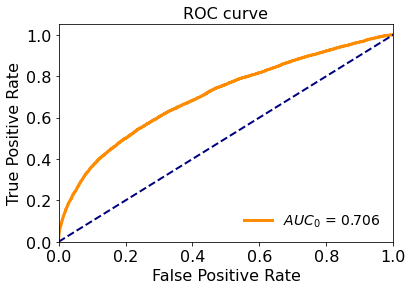

In [70]:
model_597 = LinearSVC(C = 100.0, tol =1.0)
model_597.fit(xtrain_597, ytrain_597)


y_score_597 = model_597.predict(xtest_597)

cclf = CalibratedClassifierCV(base_estimator=model_597, cv=5)
cclf.fit(xtrain_597, ytrain_597)
y_pred = cclf.predict(xtest_597)
y_score_597 = cclf.predict_proba(xtest_597)
fpr0, tpr0, _ = roc_curve(ytest_597, y_score_597[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### 3 - LinearSVC_Bilanciato

In [14]:
optimals_sb_597 = gridsearch_linearsvc(xtrain_sb_597, ytrain_sb_597, xtest_sb_597, ytest_sb_597, k_fold, tuned_parameters, scores)

# Tuning hyper-parameters for ----> roc_auc



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Best parameters set found on development set:

{'C': 10.0, 'tol': 0.1}

Grid scores on development set:

0.622 (+/-0.018) for {'C': 0.001, 'tol': 1.0}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 0.1}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 0.01}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 0.001}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 0.0001}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 1e-05}
0.622 (+/-0.018) for {'C': 0.001, 'tol': 1e-06}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 1.0}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 0.1}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 0.01}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 0.001}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 0.0001}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 1e-05}
0.652 (+/-0.020) for {'C': 0.05, 'tol': 1e-06}
0.629 (+/-0.019) for {'C': 0.01, 'tol': 1.0}
0.629 (+/-0.019) for {'C': 0.01, 'tol': 0.1}
0.629 (+/-0.019) for {'C': 0.01, 'tol': 0.01}
0.629 (+/-0.019) for {'C': 0.01, 'tol': 0.001}
0.629 (+/-0.019) for {'C': 0.01, 'tol': 0.0001}
0.629 (

In [15]:
optimals_sb_597

{'roc_auc': {'C': 10.0, 'tol': 0.1}}

0.7141923307616583


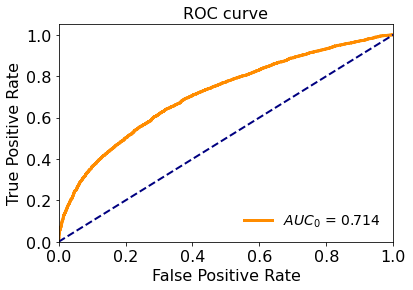

In [16]:
model_sb_597 = LinearSVC(C = 10.0, tol =0.1)
model_sb_597.fit(xtrain_sb_597, ytrain_sb_597)


y_score_sb_597 = model_sb_597.predict(xtest_sb_597)

cclf = CalibratedClassifierCV(base_estimator=model_sb_597, cv=5)
cclf.fit(xtrain_sb_597, ytrain_sb_597)
y_pred = cclf.predict(xtest_sb_597)
y_score_sb_597 = cclf.predict_proba(xtest_sb_597)
fpr0, tpr0, _ = roc_curve(ytest_sb_597, y_score_sb_597[:, 1])
roc_auc0 = auc(fpr0, tpr0)
print(roc_auc0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 4 - NN

In [72]:
def build_model_1( X_train):
    optimizer='adagrad'
    #optimizer='adam'
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["AUC"])
    return model

In [73]:
def build_model_2(X_train):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
    sgd = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["AUC"])
    return model

In [74]:
model1_597 = build_model_1(xtrain_597)
history1_597 = model1_597.fit(xtrain_597, ytrain_597, validation_data=(xtest_597, ytest_597), epochs=30, batch_size=10).history

model2_597 = build_model_2(xtrain_597)
history2_597 = model2_597.fit(xtrain_597, ytrain_597, validation_data=(xtest_597, ytest_597), epochs=30, batch_size=50).history

Epoch 1/30
12370/12370 [==============================] - 16s 1ms/step - loss: 0.3221 - auc: 0.5824 - val_loss: 0.3160 - val_auc: 0.6208
Epoch 2/30
12370/12370 [==============================] - 15s 1ms/step - loss: 0.3129 - auc: 0.6183 - val_loss: 0.3107 - val_auc: 0.6292
Epoch 3/30
12370/12370 [==============================] - 15s 1ms/step - loss: 0.3112 - auc: 0.6275 - val_loss: 0.3102 - val_auc: 0.6338
Epoch 4/30
12370/12370 [==============================] - 15s 1ms/step - loss: 0.3107 - auc: 0.6318 - val_loss: 0.3097 - val_auc: 0.6374
Epoch 5/30
12370/12370 [==============================] - 15s 1ms/step - loss: 0.3102 - auc: 0.6361 - val_loss: 0.3092 - val_auc: 0.6412
Epoch 6/30
12370/12370 [==============================] - 16s 1ms/step - loss: 0.3096 - auc: 0.6403 - val_loss: 0.3087 - val_auc: 0.6456
Epoch 7/30
12370/12370 [==============================] - 15s 1ms/step - loss: 0.3090 - auc: 0.6440 - val_loss: 0.3081 - val_auc: 0.6506
Epoch 8/30
12370/12370 [=================

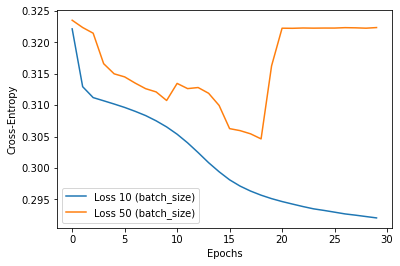

In [75]:
plt.plot(history1_597['loss'], label='Loss 10 (batch_size)')
plt.plot(history2_597['loss'], label='Loss 50 (batch_size)')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

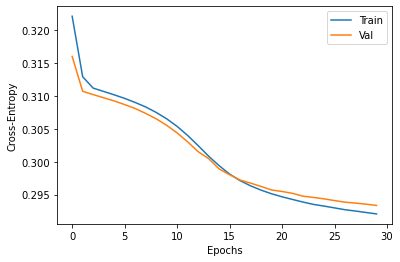

In [76]:
plt.plot(history1_597['loss'], label='Train')
plt.plot(history1_597['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

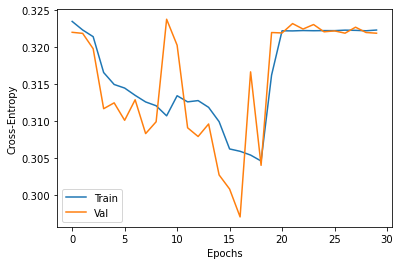

In [77]:
plt.plot(history2_597['loss'], label='Train')
plt.plot(history2_597['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [78]:
test_loss_1_597, test_auc_1_597 = model1_597.evaluate(xtest_597, ytest_597)
test_loss_2_597, test_auc_2_597 = model2_597.evaluate(xtest_597, ytest_597)

print('Loss %f, AUC %f' % (test_loss_1_597, test_auc_1_597))
print('Loss %f, AUC %f' % (test_loss_2_597, test_auc_2_597))

1657/1657 [==============================] - 1s 846us/step - loss: 0.3219 - auc: 0.5000
Loss 0.293333, AUC 0.695588
Loss 0.321902, AUC 0.500000


In [79]:
def create_model(X_train, learning_rate=0.1, momentum = 0.9, nesterov = True,
                 activation = 'sigmoid', regularizer = 0.01, units=3, hidden_layers=1):
    # create model
    model = Sequential()
    #initializer = initializers.RandomUniform(minval=0, maxval=0.5, seed=None)
    model.add(Dense(units, input_dim=X_train.shape[1], activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    for i in range(1,hidden_layers):
          model.add(Dense(units, activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    model.add(Dense(1, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(regularizer)))
    sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['AUC'])
    return model

In [80]:
param_list = {'batch_size': [128],
              'epochs': [100],
             'learning_rate': [0.261],
             'momentum':[0.9],
             'nesterov':[False],
             'activation':['tanh'],
              'regularizer':[0.0001],
              'units': [10],
             'hidden_layers': [1]}

In [81]:
class Model:
    def __init__(self, loss = 0, accuracy = 0, batch_size = 0, epochs = 0, learning_rate=0, momentum=0,nesterov=False,
                activation='sigmoid', regularizer=0, units=0):
        self.accuracy_CV_list = []
        self.accuracy = accuracy
        self.loss_CV_list = []
        self.loss = loss
        self.mee_list = []
        self.mee = 0
        self.std = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.activation = activation
        self.regularizer = regularizer
        self.units = units
        self.noise = 0
    def toString(self):
        print("""{MEE: %f (+/- %0.2f), Number of Units: %d, Batch Size: %d, Epochs: %d, Learning Rate: %f, Momentum: %f,
              "Nesterov: %s, Activation: %s, Regularization: %f, Noise: %f}""" % 
              (self.mee, self.std, self.units, self.batch_size, self.epochs, self.learning_rate, self.momentum,
              self.nesterov, self.activation, self.regularizer, self.noise))

In [82]:
def GridSearchNN(X_train, Y_train, parameters, cv = 3, rand=False):
    models = []
    allNames = list(parameters)
    combinations = itertools.product(*(parameters[Name] for Name in allNames))
    searchList = []
    if rand:
        searchList = random.sample(list(combinations), k=100)
    else:
        searchList = list(combinations)
    for i in searchList:
        print(searchList.index(i), i)
        batch_size = i[0]
        epochs=i[1]
        learning_rate=i[2]
        momentum=i[3]
        nesterov=i[4]
        activation=i[5]
        regularizer=i[6]
        units = i[7]
        temp = Model(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate,
                     momentum=momentum, nesterov=nesterov, activation=activation, regularizer=regularizer, units=units)
        model = None # Clearing the NN.
        model = create_model(X_train, learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, 
                                 activation=activation, regularizer=regularizer, units=units)
        r = model.fit(X_train, Y_train,validation_split = float(1.0/cv),
                      batch_size =batch_size, epochs=epochs, verbose=1)
        loss = r.history['val_loss'][-1]
        #accuracy = r.history['val_acc'][-1]
        temp.loss = loss
        #temp.accuracy = accuracy
        models.append(temp) 
          
    result = sorted(models, key=lambda x: x.loss, reverse=False)
    return result, r, model

In [83]:
allModels_597, r_597, model_597 = GridSearchNN(xtrain_597, ytrain_597, param_list, cv=3, rand=False)

0 (128, 100, 0.261, 0.9, False, 'tanh', 0.0001, 10, 1)
Epoch 1/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3254 - auc: 0.5399 - val_loss: 0.3136 - val_auc: 0.6287
Epoch 2/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3174 - auc: 0.5988 - val_loss: 0.3112 - val_auc: 0.6355
Epoch 3/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3160 - auc: 0.6099 - val_loss: 0.3145 - val_auc: 0.6389
Epoch 4/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3170 - auc: 0.6053 - val_loss: 0.3138 - val_auc: 0.6412
Epoch 5/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3158 - auc: 0.6112 - val_loss: 0.3101 - val_auc: 0.6440
Epoch 6/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3159 - auc: 0.6114 - val_loss: 0.3100 - val_auc: 0.6454
Epoch 7/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3157 - auc: 0.6154 - val_loss: 0.3180 - val_auc: 0.6462
Epoch 8/100
64

Epoch 62/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3157 - auc: 0.6179 - val_loss: 0.3103 - val_auc: 0.6538
Epoch 63/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3159 - auc: 0.6165 - val_loss: 0.3179 - val_auc: 0.6500
Epoch 64/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3158 - auc: 0.6140 - val_loss: 0.3148 - val_auc: 0.6536
Epoch 65/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3158 - auc: 0.6133 - val_loss: 0.3102 - val_auc: 0.6526
Epoch 66/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3149 - auc: 0.6226 - val_loss: 0.3093 - val_auc: 0.6551
Epoch 67/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3155 - auc: 0.6173 - val_loss: 0.3125 - val_auc: 0.6559
Epoch 68/100
645/645 [==============================] - 1s 2ms/step - loss: 0.3157 - auc: 0.6143 - val_loss: 0.3096 - val_auc: 0.6545
Epoch 69/100
645/645 [==============================] - 1s 2ms

In [84]:
pred_597 = model_597.predict_classes(xtest_597)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [85]:
y_pred_keras_597 = model_597.predict(xtest_597).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_597, y_pred_keras_597)
auc_keras_597 = auc(fpr_keras, tpr_keras)

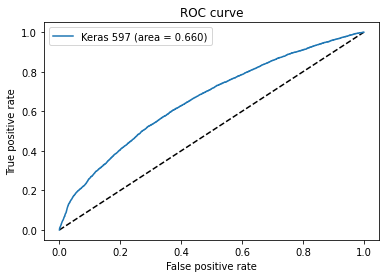

In [86]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 597 (area = {:.3f})'.format(auc_keras_597))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 4 - NN_Bilanciato

In [87]:
model1_sb_597 = build_model_1(xtrain_sb_597)
history1_sb_597 = model1_sb_597.fit(xtrain_sb_597, ytrain_sb_597, validation_data=(xtest_sb_597, ytest_sb_597), epochs=30, batch_size=10).history

model2_sb_597 = build_model_2(xtrain_sb_597)
history2_sb_597 = model2_sb_597.fit(xtrain_sb_597, ytrain_sb_597, validation_data=(xtest_sb_597, ytest_sb_597), epochs=30, batch_size=50).history

Epoch 1/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6917 - auc: 0.5478 - val_loss: 0.6907 - val_auc: 0.5928
Epoch 2/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6891 - auc: 0.5943 - val_loss: 0.6868 - val_auc: 0.6111
Epoch 3/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6827 - auc: 0.6089 - val_loss: 0.6776 - val_auc: 0.6191
Epoch 4/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6722 - auc: 0.6182 - val_loss: 0.6681 - val_auc: 0.6228
Epoch 5/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6670 - auc: 0.6239 - val_loss: 0.6662 - val_auc: 0.6260
Epoch 6/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6655 - auc: 0.6283 - val_loss: 0.6652 - val_auc: 0.6295
Epoch 7/30
2439/2439 [==============================] - 3s 1ms/step - loss: 0.6645 - auc: 0.6321 - val_loss: 0.6644 - val_auc: 0.6329
Epoch 8/30
2439/2439 [==============================] - 3s 1ms

In [88]:
test_loss_1_sb_597, test_auc_1_sb_597 = model1_sb_597.evaluate(xtest_sb_597, ytest_sb_597)
test_loss_2_sb_597, test_auc_2_sb_597 = model2_sb_597.evaluate(xtest_sb_597, ytest_sb_597)

print('Loss %f, AUC %f' % (test_loss_1_sb_597, test_auc_1_sb_597))
print('Loss %f, AUC %f' % (test_loss_2_sb_597, test_auc_2_sb_597))

327/327 [==============================] - 0s 1ms/step - loss: 0.6488 - auc: 0.6987
Loss 0.635597, AUC 0.686511
Loss 0.648818, AUC 0.698730


In [90]:
allModels_sb_597, r_sb_597, model_sb_597 = GridSearchNN(xtrain_sb_597, ytrain_sb_597, param_list, cv=3, rand=False)

0 (128, 100, 0.261, 0.9, False, 'tanh', 0.0001, 10, 1)
Epoch 1/100
127/127 [==============================] - 1s 4ms/step - loss: 0.6925 - auc: 0.5413 - val_loss: 0.6883 - val_auc: 0.6233
Epoch 2/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6796 - auc: 0.5892 - val_loss: 0.6717 - val_auc: 0.6280
Epoch 3/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6734 - auc: 0.6091 - val_loss: 0.6814 - val_auc: 0.6330
Epoch 4/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6721 - auc: 0.6133 - val_loss: 0.6683 - val_auc: 0.6371
Epoch 5/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6745 - auc: 0.6070 - val_loss: 0.6743 - val_auc: 0.6405
Epoch 6/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6731 - auc: 0.6117 - val_loss: 0.6689 - val_auc: 0.6430
Epoch 7/100
127/127 [==============================] - 0s 2ms/step - loss: 0.6717 - auc: 0.6150 - val_loss: 0.6665 - val_auc: 0.6448
Epoch 8/100
12

In [91]:
pred_sb_597 = model_sb_597.predict_classes(xtest_sb_597)

In [92]:
y_pred_keras_sb_597 = model_sb_597.predict(xtest_sb_597).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_sb_597, y_pred_keras_sb_597)
auc_keras_sb_597 = auc(fpr_keras, tpr_keras)

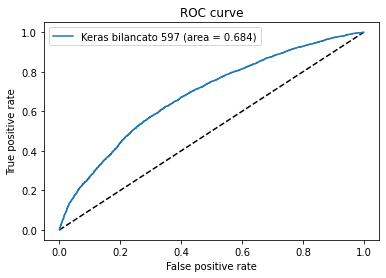

In [93]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras bilancato 597 (area = {:.3f})'.format(auc_keras_sb_597))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# ----- Curve d'apprendimento

In [10]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

In [11]:
def plot_learning_dt(X1, y1, X2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
    title = "Decision Tree G1"
    plot_learning_curve(estimator, title, X1, y1, axes=axes[0], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    print("done")
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = tree.DecisionTreeClassifier(criterion = "gini", max_depth = None, min_samples_leaf = 20, min_samples_split = 10)
    title = "Decision Tree G1 Bilanciato"
    plot_learning_curve(estimator, title, X2, y2, axes=axes[1], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    plt.show()

KeyboardInterrupt: 

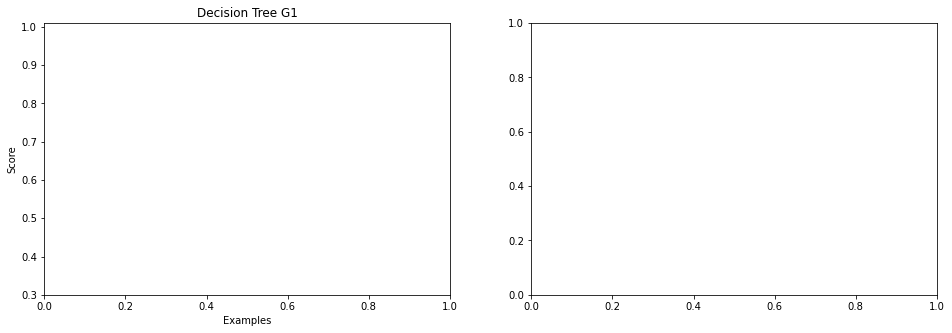

In [14]:
plot_learning_dt(xtrain_597, ytrain_597, xtrain_sb_597, ytrain_sb_597)

In [ ]:
def plot_learning_regr(X1, y1, X2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = LogisticRegression()
    title = "Logistic Regression 597"
    plot_learning_curve(estimator, title, X1, y1, axes=axes[0], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    estimator = LogisticRegression()
    title = "Logistic Regression 597 Bilanciato"
    plot_learning_curve(estimator, title, X2, y2, axes=axes[1], ylim=(0.3, 1.01),
                        cv=cv, n_jobs=10)
    plt.show()

In [ ]:
plot_learning_regr(xtrain_597, ytrain_597, xtrain_sb_597, ytrain_sb_597)